<a href="https://colab.research.google.com/github/Ayuniarfina/Final-Project-Bangkit---JKT4-B/blob/Deni-branch/improvedmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Improved model

In [144]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [255]:
import zipfile
zipref = zipfile.ZipFile('/content/gdrive/My Drive/Data Colab/faceexp.zip')
zipref.extractall('/tmp/dataset')

In [256]:
import tensorflow as tf
import collections
import matplotlib.pyplot as plt

In [257]:
import shutil
#shutil.rmtree('/tmp/dataset')
shutil.rmtree('/tmp/dataset/images/images/train/neutral')
shutil.rmtree('/tmp/dataset/images/images/validation/neutral')

In [258]:
train_dir = ('/tmp/dataset/images/images/train')
test_dir = ('/tmp/dataset/images/images/validation')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
  #rotation_range=40,
  #width_shift_range=0.2,
  #height_shift_range=0.2,
  horizontal_flip=True,
  #fill_mode='nearest' 
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

traingenerator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

testgenerator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='categorical',
    shuffle=False
)

Found 23839 images belonging to 6 classes.
Found 5850 images belonging to 6 classes.


In [259]:
print (traingenerator.class_indices)

labels = '\n'.join(sorted(traingenerator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5}


In [260]:
!cat labels.txt

angry
disgust
fear
happy
sad
surprise

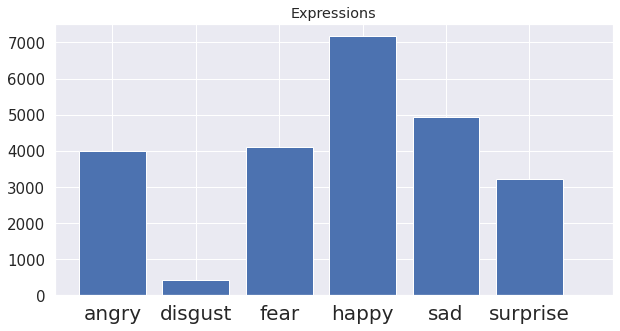

 
Counter({3: 7164, 4: 4938, 2: 4103, 0: 3993, 5: 3205, 1: 436})


In [261]:
trainset = collections.Counter(traingenerator.classes)
plt.figure(figsize=(10,5))
plt.bar(trainset.keys(), trainset.values())
xlabel = ['angry','disgust','fear','happy','sad','surprise']
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=xlabel)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=15)
plt.title('Expressions')
plt.show()
print(' ')
print(trainset)

In [262]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top= False,
    weights= 'imagenet',
    input_shape= (150,150,3)
)

for layer in pre_trained_model.layers:
  layer.trainable = False

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x= tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.25)(x)
x= tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input,x)
#model.summary()

In [263]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(traingenerator, epochs=5, validation_data=testgenerator)

Epoch 1/5
745/745 [==============================] - 61s 83ms/step - loss: 1.2595 - acc: 0.5139 - val_loss: 1.0744 - val_acc: 0.5836
Epoch 2/5
745/745 [==============================] - 61s 82ms/step - loss: 1.0636 - acc: 0.5832 - val_loss: 1.0126 - val_acc: 0.6070
Epoch 3/5
745/745 [==============================] - 61s 82ms/step - loss: 0.9933 - acc: 0.6056 - val_loss: 1.0101 - val_acc: 0.6068
Epoch 4/5
745/745 [==============================] - 62s 83ms/step - loss: 0.9321 - acc: 0.6297 - val_loss: 0.9666 - val_acc: 0.6202
Epoch 5/5
745/745 [==============================] - 61s 82ms/step - loss: 0.8893 - acc: 0.6448 - val_loss: 0.9812 - val_acc: 0.6234


In [213]:
#Fine Tune Model
for layer in pre_trained_model.layers:
  layer.trainable = True

print('Number of layers: ', len(pre_trained_model.layers))

fine_tune_at = 200

for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers:  311


In [214]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history_refined = model.fit_generator(traingenerator, epochs=6,initial_epoch= history.epoch[-1], validation_data=testgenerator)

Epoch 3/6
745/745 [==============================] - 74s 100ms/step - loss: 0.7640 - acc: 0.7023 - val_loss: 0.9938 - val_acc: 0.6444
Epoch 4/6
745/745 [==============================] - 73s 98ms/step - loss: 0.6073 - acc: 0.7664 - val_loss: 0.9756 - val_acc: 0.6598
Epoch 5/6
745/745 [==============================] - 73s 98ms/step - loss: 0.4775 - acc: 0.8223 - val_loss: 1.0509 - val_acc: 0.6663
Epoch 6/6
745/745 [==============================] - 73s 98ms/step - loss: 0.3733 - acc: 0.8620 - val_loss: 1.0844 - val_acc: 0.6687


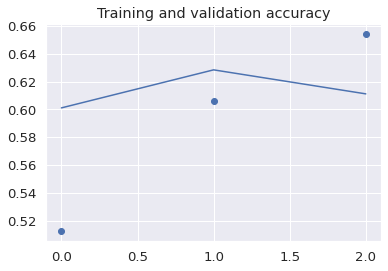

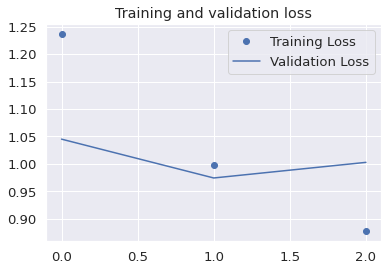

In [215]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(figsize=(10,5))
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [216]:
# Evaluate Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random

In [217]:
# Using test generator dataset
Y_pred = model.predict(testgenerator)
y_pred = np.argmax(Y_pred, axis=1)

actual = collections.Counter(testgenerator.classes)
prediction = collections.Counter(y_pred)

X = ['angry','disgust','fear','happy','sad','surprise']
Y=[]
Z=[]

for i in range(len(xlabel)):
  Y.append(actual[i])
  Z.append(prediction[i])

In [218]:
print('actual:',actual)
print('prediction:',prediction)

actual: Counter({3: 1825, 4: 1139, 2: 1018, 0: 960, 5: 797, 1: 111})
prediction: Counter({3: 1776, 2: 1294, 4: 1111, 0: 830, 5: 786, 1: 53})


In [219]:
# Plot Random N Missclassified Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tes1 = testgenerator.classes
tes2 = y_pred
diff = tes1-tes2

In [220]:
#Initiatialize
x=[]
y=0
labels = ['angry','disgust','fear','happy','sad','surprise']
#Calculate False Prediction Location (x)
for i in range(len(diff)):
  if diff[i]>0 or diff[i]<0:
    x.append(i)
    y+=1

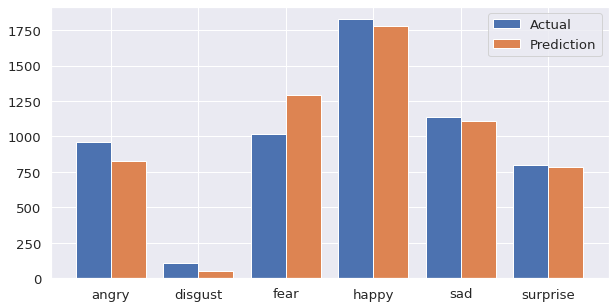

In [221]:
def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    plt.figure(figsize=(10,5))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.legend(['Actual', 'Prediction'])
    plt.xticks(_X, X)
    
subcategorybar(X, [Y,Z])

plt.show()

Total Images:  5850
Number of Images Missclassified:  1938
 


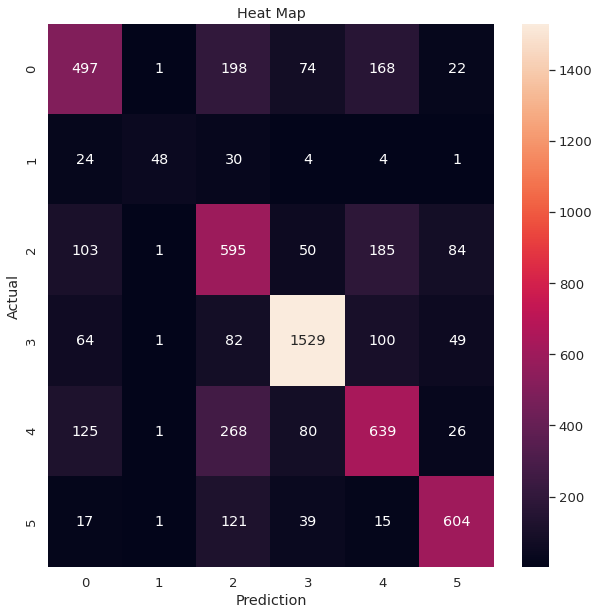

In [222]:
import seaborn as sn
import pandas as pd

print('Total Images: ',len(tes1))
print('Number of Images Missclassified: ',y)
print(' ')


array= confusion_matrix(testgenerator.classes,y_pred)

plt.subplots(figsize=(10,10))
df_cm=pd.DataFrame(array, range(6),range(6))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title('Heat Map')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [223]:
# Hitung Accuracy per class, manual
#actual: Counter({3: 1825, 4: 1216, 5: 1139, 2: 1018, 0: 960, 6: 797, 1: 111})
print('0: ', 254/960 )
print('1: ', 34/111)
print('2: ', 350/1018)
print('3: ', 1465/1825)
print('4: ', 520/1216)
print('5: ', 478/1139)
print('6: ', 503/797)

0:  0.26458333333333334
1:  0.3063063063063063
2:  0.343811394891945
3:  0.8027397260273973
4:  0.4276315789473684
5:  0.4196663740122915
6:  0.6311166875784191


In [224]:
# Classification Report

target_names = ['angry','disgust','fear','happy','sad','surprise']
print(classification_report(testgenerator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.60      0.52      0.56       960
     disgust       0.91      0.43      0.59       111
        fear       0.46      0.58      0.51      1018
       happy       0.86      0.84      0.85      1825
         sad       0.58      0.56      0.57      1139
    surprise       0.77      0.76      0.76       797

    accuracy                           0.67      5850
   macro avg       0.69      0.62      0.64      5850
weighted avg       0.68      0.67      0.67      5850



In [ ]:
#Print N Random Misclassified Images (limit==N)
limit=0
dir = ('/tmp/dataset/images/images/validation')
while True:
  limit+=1
  nomor = random.sample(x,1)
  print(#testgenerator.filenames[(nomor[0])],
        'actual:', labels[tes1[(nomor[0])]], '/ prediction:', labels[tes2[(nomor[0])]])
  plt.imshow(mpimg.imread(dir+'/'+testgenerator.filenames[(nomor[0])]))
  plt.show()

  if limit == 20:
    break

In [ ]:
basedir = ('/tmp/dataset/images/images/validation/')
expression = ('sad')
nsample = 25
import os
listname = os.listdir(basedir+expression)
test = random.sample(listname, nsample)
tests=0
for i in test:
  plt.subplots(figsize=(4,4))
  dir = basedir+expression+'/'+i
  plt.imshow(mpimg.imread(dir),cmap='gray')
plt.show()

In [226]:
#Save Model
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')

In [230]:
files.download('labels.txt')

In [252]:
tf.keras.backend.clear_session()

In [253]:
del history